In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import seaborn as sns
import random
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download("stopwords")
import re
import math
import streamlit as st
from imageio import imread

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a8509\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load in the dataframe
dataset = 'scrapeDF_273_Iphone'
dataset_name = dataset.split('_')
dataset_name = dataset_name[len(dataset_name) - 1]
path = 'data/'
df = pd.read_csv(path + dataset + '.csv', index_col=0)
newData = df.groupby('stream')
twitter_df = list(df.groupby('stream'))[1][1]

In [3]:
# set n-gram
ngram_name = 'Bigram'

In [4]:
# set n-gram
if ngram_name.lower() == 'unigram':
    ngram = 1
elif ngram_name.lower() == 'bigram':
    ngram = 2

In [5]:
brand = dataset_name
STOP_WORDS = stopwords.words('english')
STOP_WORDS.extend(list(STOPWORDS))
STOP_WORDS = set(STOP_WORDS)

In [6]:
def clean_text(text):
    brand_lower = brand.lower()
    temp = text.lower()
    if brand.lower() == 'iphone':
        temp = re.sub(brand_lower + ' [0-9]+', '', temp) # for iphone model
        temp = re.sub(brand_lower + '[0-9]+', '', temp) # for iphone model
        temp = re.sub('apple', '', temp)
    temp = re.sub(brand_lower, ' ', temp)
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # hashtags
    temp = re.sub(r"http\S+", "", temp) # weblinks
    temp = re.sub(r"www.\S+", "", temp) # websites
    temp = re.sub('[()!?]', ' ', temp) # punctuation
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub('\.\Z', '', temp) # remove dot but not remove decimal point
    temp = re.sub('\.\s+', ' ', temp) # remove dot but not remove decimal point
    reg_float='^\d+\.\d+$'
    temp = re.sub("[^a-z0-9.]"," ", temp) # non alpha numeric dot
    temp = temp.split()
    temp = [w for w in temp if not w in STOP_WORDS]
    temp = " ".join(word for word in temp)
    return temp

In [7]:
# generate n-gram words
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [8]:
twitter_df['text_with_stopw'] = twitter_df.text.apply(lambda x:clean_text(x))

In [9]:
def RemoveDuplicate(list_of_words):
    final_list = []
    for word in list_of_words:
        if word not in final_list:
            final_list.append(word)
    return final_list

In [10]:
class AssignColour(object):
    
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

In [11]:
from nltk.corpus import stopwords
original_twitter_words = []
twitter_ngram = defaultdict(int)

for tweet in twitter_df['text_with_stopw']:
    for word in generate_ngrams(tweet.split(), n_gram=ngram):
        original_twitter_words.append(word)
        twitter_ngram[word] += 1

twitter_words = RemoveDuplicate(original_twitter_words)
twitter_cleaned_lines = dict()
twitter_pos_words = []
twitter_neg_words = []

In [12]:
sia = SentimentIntensityAnalyzer()
for r in twitter_words:
    if not r.lower() in STOP_WORDS:
        neg_polarity = sia.polarity_scores(r)['neg']
        pos_polarity = sia.polarity_scores(r)['pos']
        cpd_polarity = sia.polarity_scores(r)['compound']
        sentiment = (neg_polarity+pos_polarity)*cpd_polarity
        
        if(sentiment != 0):
            twitter_cleaned_lines[r] = sentiment

In [13]:
#twitter
for key, value in twitter_cleaned_lines.items():
    if(value > 0):
        twitter_pos_words.append(key)
    else:
        twitter_neg_words.append(key)  

In [14]:
# pos color: orange
# neg color: black

twitter_colour_words_dict = {
    'orange': twitter_pos_words,
    'black':   twitter_neg_words
}

In [15]:
# pos color: orange
# neg color: black
# neutral words are green
twitter_logo = imread('logo/twitter_logo.png')

twitter_grouped_colour_func = AssignColour(twitter_colour_words_dict, 'green')

twitter_wc = WordCloud(mask = twitter_logo, width=2000, height=1000, 
                       max_words = 1000, collocations = False, background_color = 'white', 
                       color_func=twitter_grouped_colour_func).generate_from_frequencies(twitter_ngram) 

2022-05-28 15:58:14.150 
  command:

    streamlit run C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

<Figure size 432x288 with 0 Axes>

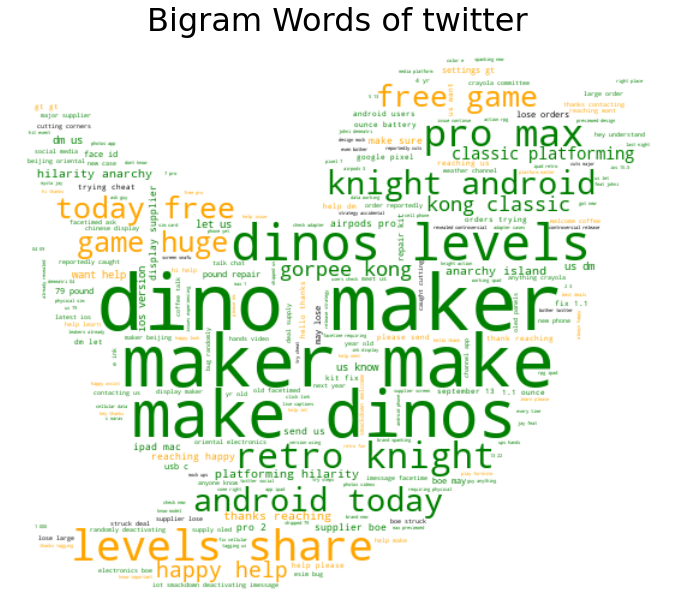

In [16]:
# show twitter word cloud
fd = {
    'fontsize': '32',
    'fontweight' : 'normal',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center',
}
plt.figure()
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(twitter_wc, interpolation='bilinear')
ax.axis('off')
ax.set_title(f'{ngram_name} Words of twitter', pad=24,
             fontdict=fd)
#plt.savefig(f'{ngram_name}_wordCloud_{brand}.jpg',dpi=560)
#plt.show()
st.pyplot(fig)